# (16b) MLE probabilistic inference using the LNA on molecule number for TR volume dep

In this notebook we try a very different inference technique. First we fit the mean predicted by the model and use a least square fitting to determine $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$, reducing the number of parameters needed to be inferred by 2 - leaving 2 parameters needing to be inferred. Then we use the LNA to approximate the time evolution of each generation and calculate the probability of having the set of experimental measurements in each lineage given at parameter set $\{\alpha_0, \alpha_1, \beta_0, \beta_1\}$. We maximise this probability in order to infer the parameters for the given lineage.

In this notebook our sole focus is on the inference of articial simulated data for which we know the parameters.

First we import the Tanouchi data from the $37^{\circ}C$ dataset. We do this to get the required data form for our simulated data later on.

In [1]:
include("./SSA_file.jl"); using .SSAmod;
include("./extract_gens.jl"); using .extract;
using DelimitedFiles;

In [2]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(sort!(filelist))
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

In [3]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # non-separated fluor data.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # non-separated vol data.

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage sep into gens.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage sep into gens.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt data for each lineage sep into gens.

fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

num_sep_all_lins = []; # sep into gens.
conc_sep_all_lins = [];
for i in 1:length(fluor_sep_all_lins)
    num_i = fluor_sep_all_lins[i]./fpm;
    conc_i = [num_i[y] ./ vol_sep_all_lins[i][y] for y in 1:length(vol_sep_all_lins[i])];
    push!(num_sep_all_lins,num_i);
    push!(conc_sep_all_lins,conc_i);
end

# un-sep molecule number and concs for each lineage (including 70th gen to be removed) later).
num_all_lins = [fluor_all_lins[x]./fpm for x in 1:length(fluor_all_lins)];
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm;
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

Now let's plot the first 10 generations of the first lineage of 37$^{\circ}C$ Tanouchi data. Later we wish to infer parameters of simulated data that at a glance resembles this experimental data.

In [4]:
using Plots, Statistics, StatsBase, Distances, Distributions, LaTeXStrings, LinearAlgebra; pyplot();

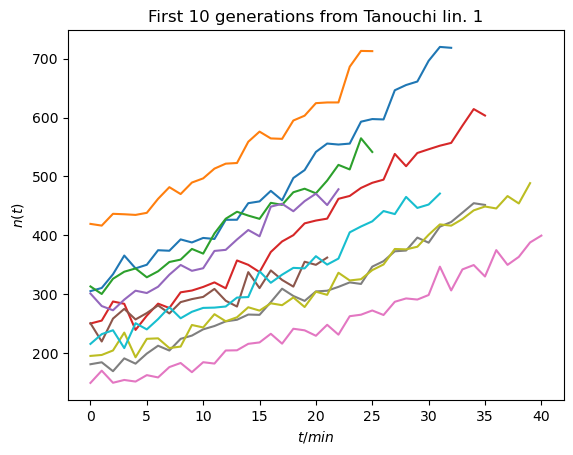

In [5]:
e_gen = 1;
num_gens = deepcopy(num_sep_all_lins[e_gen]);
fig, ax = PyPlot.subplots(1,1);
for i in 1:10#length(conc_gens)
    ax.plot(num_gens[i])
end
PyPlot.xlabel(L"t/min"); PyPlot.ylabel(L"n(t)"); PyPlot.title("First 10 generations from Tanouchi lin. 1")
PyPlot.show()

Create an artificial set of all lineage data using transcription rate volume dependent parameters. Then plot the artificial lineages.

In [7]:
true_par = [0.1,1.0,0.5,1E-6];

In [41]:
function Single_lin(lin_data::Array{Array{Float64,1},1}, inf_par::Array{Float64,1}, ics::Array{Any,1}) # arguments are wrt each lineage.
    SSA_data_n = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA_deg_zero_log(1, inf_par, ics[i], length(gen)); # for each gen run the SSA with correct ics.
        push!(SSA_data_n, ssa[1][:]);
    end
    return vcat(SSA_data_n)# return in the same order as the SSA.
end

Single_lin (generic function with 1 method)

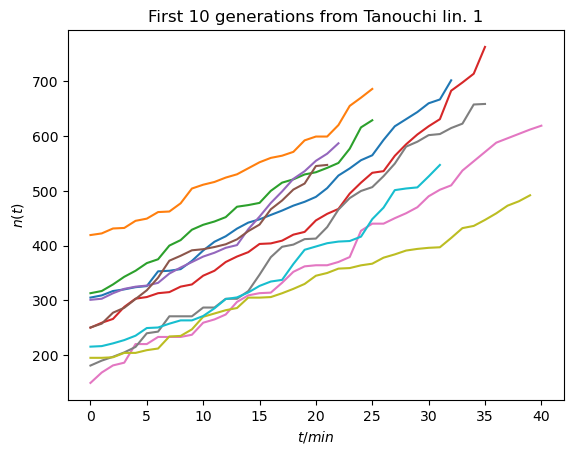

In [95]:
art_data_all_lins = []; # the artificial data of all lineages.
for x in 1:length(num_sep_all_lins)
    lineage_data = num_sep_all_lins[x]; # take the data for the x'th lineage, this gives the data form for Single_lin.
    lin_ic = v0_n0_th[x];               # pre-set params for lineage x.
    
    push!(art_data_all_lins,Single_lin(lineage_data, true_par, lin_ic)) # append the x'th fake lineage 
end

e_gen = 1;
num_gens = deepcopy(art_data_all_lins[e_gen]);

fig, ax = PyPlot.subplots(1,1);
for i in 1:10#length(conc_gens)
    ax.plot(num_gens[i])
end
PyPlot.xlabel(L"t/min"); PyPlot.ylabel(L"n(t)"); PyPlot.title("First 10 generations from Tanouchi lin. 1")
PyPlot.show()

Since the model we are attempting to fit the data to is formed of only 1 linear reaction, i.e., $\varnothing \xrightarrow{\alpha_0 V(t)^{\alpha_1}} m P$, with $m \sim \text{Geom}(\beta_0 V(t)^{\beta_1})$, the rate equation for this process gives the exact evolution of the mean of this process. Solving the rate equation for this process we find:
$$ \langle n(t)\rangle = \frac{\alpha_0\beta_0 V_0^{\alpha_1+\beta_1}}{(\alpha_1+\beta_1)\theta}\left(e^{(\alpha_1+\beta_1)\theta t} -1 \right) + \langle n(0)\rangle$$

We now fit this each to each generation in the lineage using the method of least squares, and in doing so obtaining values of $\alpha_0\beta_0$ and $\alpha_1+\beta_1$ for each lineage. Our task is then to find the value best representing $\alpha_0\beta_0$ and $\alpha_1+\beta_1$ over the entire lineage, and compare to what should be the true values seen in `true_par`.

In [43]:
using LsqFit; # least square fitting package

In [44]:
comb_pars = [];
for i in 1:length(v0_n0_th[e_gen])
    v0 = v0_n0_th[e_gen][i][1]; n0 = v0_n0_th[e_gen][i][2]; th = v0_n0_th[e_gen][i][3];
    m(t,ab) = ((10 .^ab[1]*v0^(10 .^ab[2]))/(10 .^ab[2]*th)).*(exp.(10 .^ab[2]*th.*t) .-1) .+ 10 .^ab[3];
    ab0 = [0.1, 0.1, 2.0];
    n_data = num_gens[i];
    fit = 10 .^curve_fit(m, LinRange(1,length(n_data), length(n_data)), n_data, ab0).param
    push!(comb_pars,fit)
end
comb_pars = convert(Array{Float64,2},transpose(hcat(comb_pars...)))

69×3 Array{Float64,2}:
  1.60978    1.81192      279.039
 17.822      1.8308e-8    375.717
  0.252907   2.85133      332.87
  3.6119     1.11277      234.472
  1.74692    1.66759      302.644
  0.0782019  4.45665      247.411
  3.88815    0.956656     146.713
  7.46792    0.443374     171.57
  4.77392    0.69801      182.764
  6.46659    0.614155     221.119
  5.4253     0.877732     172.133
  3.50049    1.27258      220.468
  1.66344    1.45405      258.782
  ⋮                       
  6.82836    0.566088     199.289
 11.0238     1.28464e-10  263.756
  8.69077    0.175653     197.335
  2.35678    1.38882      203.671
  7.3907     0.31639      218.3
  7.58556    0.569183     179.791
 10.9039     0.278297     207.356
  4.88157    0.689088     209.459
  5.48677    0.600906     167.0
  2.62844    1.31189      210.266
  2.53737    1.20193      209.409
  4.7841     0.748519     271.655

Now let's just check that the individual values of $\alpha_0\beta_0$ and $\alpha_1+\beta_1$ determined for each trajectory are well fit.

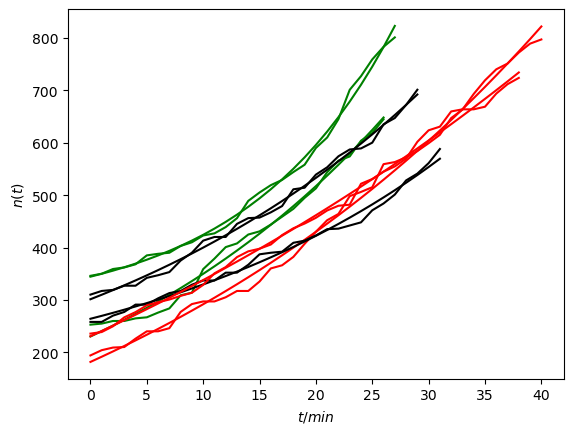

In [45]:
avg_traj = [];
for i in 1:length(v0_n0_th[1])
    v0 = v0_n0_th[e_gen][i][1]; n0 = v0_n0_th[e_gen][i][2]; th = v0_n0_th[e_gen][i][3];
    ab = comb_pars[i,:];
    traj = [((ab[1]*v0^(ab[2]))/((ab[2])*th))*(exp.((ab[2])*th*t) .-1) .+ ab[3] for t in 1:length(num_gens[i])];
    push!(avg_traj,traj)
end

#print(avg_traj[1]);
colors = ["r","g","black","r","g","black","r","g","black"];
fig, ax = PyPlot.subplots(1,1);
for i in 1:6#length(conc_gens)
    ax.plot(num_gens[i+10], color = colors[i])
    ax.plot(avg_traj[i+10], color = colors[i])
end
PyPlot.xlabel(L"t/min"); PyPlot.ylabel(L"n(t)")
PyPlot.show()

Now plot the histograms for the determined values of $\alpha_0\beta_0$ and $\alpha_1+\beta_1$.

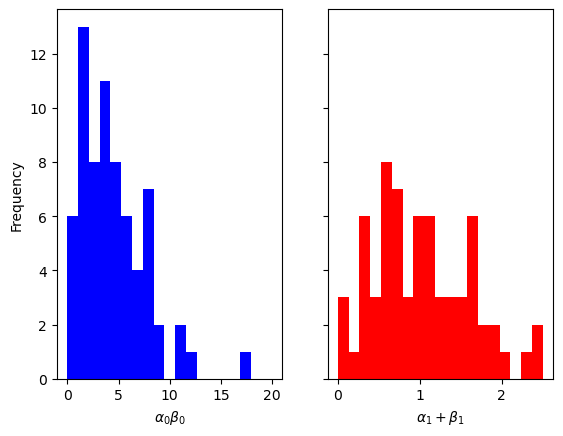

In [46]:
fig, ax = PyPlot.subplots(1,2, sharey = true)

ax[1].hist(comb_pars[:,1], bins = LinRange(0.0, 20, 20), color = "b"); ax[1].set_ylabel("Frequency"), ax[1].set_xlabel(L"\alpha_0 \beta_0");
ax[2].hist(comb_pars[:,2], bins = LinRange(0.0, 2.5, 20), color = "r"); ax[2].set_xlabel(L"\alpha_1 + \beta_1");

Let's compare the true values of $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$ to the mean values over all least square fitting.

In [47]:
av_ab_0 = sum(comb_pars[:,1])/length(comb_pars[:,1]); av_ab_1 = sum(comb_pars[:,2])/length(comb_pars[:,2]);
print("Mean Lsq values: ", av_ab_0, "\t", av_ab_1, "\n")

Mean Lsq values: 4.428785674899576	1.118835589551233


What about the median?

In [48]:
av_ab_0 = median(comb_pars[:,1]); av_ab_1 = median(comb_pars[:,2]);
print("Median Lsq values: ", av_ab_0, "\t",av_ab_1, "\n")

Median Lsq values: 3.8358515068150196	0.9819365116421472


In [49]:
lsq_a0b0 = av_ab_0; lsq_a1b1 = av_ab_1; # set this for use later on.

It seems that the median values of the histograms are the best estimate of the true parameter values, so we will use the median instead of the mean.

# Inference to determine $\{\alpha_0, \alpha_1, \beta_0, \beta_1\}$

Now, let's find the probability of having the set of experiment data point in `expt_ssa_conc` given the parameters `[0.1,1E-6,0.5,1.0]` (in order $\{\alpha_0, \alpha_1, \beta_0, \beta_1\}$, a set denoted by $\mathcal{S}$). We do this using the LNA for each generation. The variance of the process $\varnothing \xrightarrow{\alpha_0 V(t)^{\alpha_1}} m P$, with $m \sim \text{Geom}(\beta_0 V(t)^{\beta_1})$ is given by:
$$ \text{Var}(\phi(t)) = \sigma_{\phi}(t)^2 = \frac{\alpha_0\beta_0 V_0^{\alpha_1+\beta_1}}{V(t)^2 \theta}\left(\frac{e^{(\alpha_1+\beta_1)\theta t}- 1}{\alpha_1+\beta_1} + \frac{2 \beta_0 V_0^{\beta_1}}{\alpha_1+2\beta_1}\left(e^{(\alpha_1+2\beta_1)\theta t}-1 \right) \right). $$

Note that the initial condition is exactly known hence $\text{Var}(\phi(0)) = 0$. Knowing the variance we can now employ the LNA, which is a Gaussian approximation giving (for generation $j$):
$$P_j(\phi_j(t) ; \mathcal{S}) = \frac{1}{\sqrt{2 \pi}\sigma_{\phi_j}(t ; \mathcal{S})}\exp\left(-\frac{1}{2}\left(\frac{\phi_j(t)-\langle \phi_j(t ; \mathcal{S})\rangle}{\sigma_{\phi_j}(t ; \mathcal{S})} \right)^2 \right).$$

Finally, we find that the maximisation of the product of the probabilities, i.e., $\prod_{j=1}^{N}\prod_{t}^{M_j} P_j(\phi_j(t))$ (where $N$ is the number of generations and $M_j$ is the number of time points in generation $j$) - allowing us to determine the optimal parameters - is equivalent to the minimisation of the negative logarithm of $P_j(\phi_j(t) ; \mathcal{S})$, giving the new objective function:

$$ -\ln(P_j(\phi_j(t) ; \mathcal{S})) \propto L(\mathcal{S}) = \min_{\mathcal{S}} \sum_{j=1}^N\sum_{t=1}^{M_j} \left\{ \frac{1}{2}\left(\frac{\phi_j(t)-\langle \phi_j(t ; \mathcal{S})\rangle}{\sigma_{\phi_j}(t ; \mathcal{S})} \right)^2  +\ln(\sigma_{\phi_j}(t ; \mathcal{S})) \right\}. $$

We neglect the $2\pi$ from the likelihood since it is just a constant.

We will use the `BlackBoxOptim` Julia package in order to find the minimum of $L(\mathcal{S})$. We first import the package.

In [50]:
using BlackBoxOptim

Now we can write the black-box function to be optimised, which takes the inference parameters as input and outputs the likelihood.

In [51]:
function re_sol(S::Array{Float64,1}, ic_lin::Int, gen_i::Int, t::Int)
    a0, a1 = 10^S[1], 10^S[2];
    b0, b1 = lsq_a0b0/a0, lsq_a1b1 - a1;
    
    v0 = v0_n0_th[ic_lin][gen_i][1]; n0 = v0_n0_th[ic_lin][gen_i][2]; 
    th = v0_n0_th[ic_lin][gen_i][3];
    
    re_mn = ((a0*b0*v0^(a1+b1))/((a1+b1)*th))*(exp((a1+b1)*th*t)
                            -1) + n0; # get the mean conc
    
    return re_mn
end

re_sol (generic function with 1 method)

In [52]:
function sd_sol(S::Array{Float64,1}, ic_lin::Int, gen_i::Int, t::Int)
    a0, a1 = 10^S[1], 10^S[2];
    b0, b1 = lsq_a0b0/a0, lsq_a1b1 - a1;
    
    v0 = v0_n0_th[ic_lin][gen_i][1]; n0 = v0_n0_th[ic_lin][gen_i][2]; 
    th = v0_n0_th[ic_lin][gen_i][3];
    
    sd_sol = sqrt( ((a0*b0*v0^(a1+b1))/(th)) * 
                    ( ((exp((a1+b1)*th*t)-1)/(a1+b1)) + ((2*b0 * v0^b1)/(a1+2*b1)) 
                        * (exp((a1+2*b1)*th*t)-1) ) ); # get the sd
    
    return sd_sol
end

sd_sol (generic function with 1 method)

In [53]:
function bb_fn(S::Array{Float64,1})
    """ the input ps is an array of form [a0, log10(a1)] """
    
    sum_neg_log_likelihood = 0.0::Float64; # want to minimise this
    for (i,gen) in enumerate(num_gens) # loop over each gen.
        for t in 0:length(gen)-1            # loop over all times in that gen.
            if t>0                          # don't do for the first measurement in each gen.
                
                re_mn = re_sol(S, e_gen, i, t)
                sd = sd_sol(S, e_gen, i, t);   # get the sd
                meas = gen[t+1];            # get the measurement
                neg_ll = (0.5)*((meas-re_mn)/sd)^2 + log(sd); # calculate the NLL
                
                #append!(neg_log_likelihoods, neg_ll); # append to the array.
                sum_neg_log_likelihood += neg_ll;
            end
        end
    end
    return sum_neg_log_likelihood
end

bb_fn (generic function with 1 method)

In [54]:
SRange = [(-1.0, 1.0),(-3.0, log10(lsq_a1b1))];
opts = bbsetup(bb_fn; Method = :adaptive_de_rand_1_bin_radiuslimited, SearchRange = SRange, NumDimensions = 2, MaxSteps = 1e3, PopulationSize = 100)
res = bboptimize(opts);
opt_par_a = [best_candidate(res)[1], 10^best_candidate(res)[2]];
opt_par = [opt_par_a[1], opt_par_a[2], log10(lsq_a0b0/10^opt_par_a[1]), lsq_a1b1 - opt_par_a[2]];

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.53 secs, 92 evals, 48 steps, improv/step: 0.458 (last = 0.4583), fitness=8072.823354483
1.03 secs, 160 evals, 87 steps, improv/step: 0.425 (last = 0.3846), fitness=8067.919552753
1.54 secs, 257 evals, 147 steps, improv/step: 0.456 (last = 0.5000), fitness=8066.807176347
2.04 secs, 343 evals, 206 steps, improv/step: 0.442 (last = 0.4068), fitness=8054.422435770
2.55 secs, 433 evals, 275 steps, improv/step: 0.425 (last = 0.3768), fitness=8054.422435770
3.05 secs, 515 evals, 347 steps, improv/step: 0.409 (last = 0.3472), fitness=8053.410655608
3.56 secs, 611 evals, 433 steps, improv/step: 0.395 (last = 0.3372), fitness=8052.352377424
4.06 secs, 709 evals, 522 steps, improv/step: 0.400 (last = 0.4270), fitness=8051.627822963
4.59 secs, 817 evals, 624 steps, improv/step: 0.372 (last = 0.2255

In [55]:
opt_par

4-element Array{Float64,1}:
 0.10163364476523315
 0.9779174834321113
 0.48222814168462264
 0.004019028210035969

In [90]:
true_par

4-element Array{Float64,1}:
 0.1
 1.0
 0.5
 1.0e-6

In [100]:
# function that returns the SSA concentration for lineage specified abvove.
function simulator_function_conc(var_params::Array{Float64,1})
    pars = [var_params[1], var_params[2], var_params[3], var_params[4]];
    lin_num = Single_lin(num_sep_all_lins[e_gen], pars, v0_n0_th[e_gen])
    return hcat(vcat(lin_num...))
end

simulator_function_conc (generic function with 1 method)

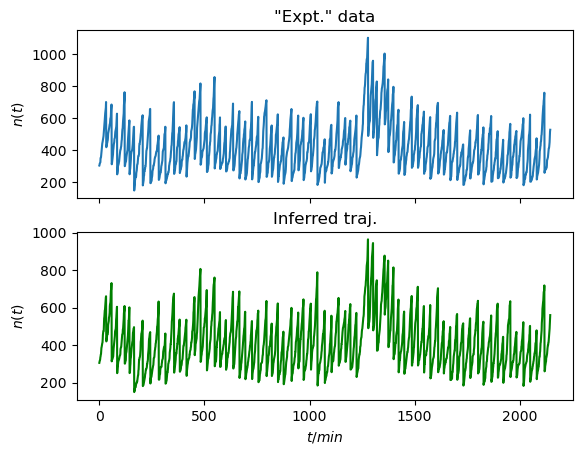

In [102]:
fig, ax = PyPlot.subplots(2,1, sharex = true);

ax[1].plot(vcat(num_gens...)); ax[1].set_title("\"Expt.\" data"); ax[1].set_ylabel(L"n(t)");
ax[2].plot(simulator_function_conc(opt_par)[:], color = "g"); ax[2].set_title("Inferred traj."); ax[2].set_ylabel(L"n(t)");
ax[2].set_xlabel(L"t/min");

# Let's automate the procedure for all lineages

In [24]:
lin_opt_pars = [];
for (x,lin) in enumerate(art_data_all_lins)
    # step 1: take lineage
    e_gen = x;
    num_gens = deepcopy(lin);
    
    # step 2: find the constrained parameters on the mean
    comb_pars = [];
    for i in 1:length(v0_n0_th[e_gen])
        v0 = v0_n0_th[e_gen][i][1]; n0 = v0_n0_th[e_gen][i][2]; th = v0_n0_th[e_gen][i][3];
        m(t,ab) = ((10 .^ab[1]*v0^(10 .^ab[2]))/(10 .^ab[2]*th)).*(exp.(10 .^ab[2]*th.*t) .-1) .+ n0;
        ab0 = [0.1, 0.1];
        n_data = num_gens[i];
        fit = 10 .^curve_fit(m, LinRange(1,length(n_data), length(n_data)), n_data, ab0).param
        push!(comb_pars,fit)
    end
    comb_pars = convert(Array{Float64,2},transpose(hcat(comb_pars...)));
    
    lsq_a0b0 = median(comb_pars[:,1]); lsq_a1b1 = median(comb_pars[:,2]);
    
    # step 3: do the MLE
    SRange = [(-1.0, 1.0),(-5.0, log10(lsq_a1b1))];
    opts = bbsetup(bb_fn; Method = :adaptive_de_rand_1_bin_radiuslimited, SearchRange = SRange, NumDimensions = 2, MaxSteps = 1e3, PopulationSize = 100, TraceMode = :silent)
    res = bboptimize(opts);
    opt_par_a = [best_candidate(res)[1], 10^best_candidate(res)[2]];
    opt_par = [opt_par_a[1], opt_par_a[2], log10(lsq_a0b0/10^opt_par_a[1]), lsq_a1b1 - opt_par_a[2]];
    
    # step 4: store these optimal par values
    push!(lin_opt_pars, opt_par)
    print(x, "\t")
end


1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	123	124	125	126	127	128	129	130	131	132	133	134	135	136	137	138	139	140	141	142	143	144	145	146	147	148	149	150	151	152	153	154	155	156	157	158	159	160	

In [25]:
lin_opt_pars_df = convert(Array{Float64,2}, transpose(hcat(lin_opt_pars...)))

160×4 Array{Float64,2}:
 -0.184507    1.0615       0.629331  0.210618
 -0.336917    1.05045      0.810032  0.0827627
 -0.0436103   1.00094      0.562007  0.143153
  0.051398    0.962163     0.53849   0.0415401
  0.145354    0.774812     0.336858  0.484423
 -0.169362    1.11619      0.673705  0.0170465
 -0.172749    1.21478      0.631448  0.0124009
  0.320685    0.489726     0.161495  0.796457
  0.181       0.0154151    0.309073  1.10266
 -0.00214669  0.909275     0.518859  0.222782
 -0.169041    1.27204      0.58953   0.0557877
  0.0550925   0.518465     0.378326  0.725321
  0.34155     0.60611      0.155087  0.629697
  ⋮                                  
  0.225764    0.000498361  0.301084  1.04039
  0.107641    0.968445     0.349644  0.35865
  0.118671    0.459721     0.309119  0.837561
 -0.0865178   0.639601     0.582567  0.477924
 -0.286695    1.16748      0.719974  0.0273569
  0.0319276   1.01718      0.492724  0.0784338
 -0.229643    1.10665      0.664097  0.163853
  0.0618383   

In [26]:
using DataFrames;

In [2]:
#df_pars = DataFrame(alpha_0 = 10 .^lin_opt_pars_df[:,1], alpha_1 = lin_opt_pars_df[:,2], beta_0 = 10 .^lin_opt_pars_df[:,3], beta_1 = lin_opt_pars_df[:,4], a0b0 = 10 .^(lin_opt_pars_df[:,1]+lin_opt_pars_df[:,3]), a1_plus_b1 = lin_opt_pars_df[:,2]+lin_opt_pars_df[:,4])
#using CSV; CSV.write("Tan_MLE_inf/df_37_tan_TRvoldep.csv", df_pars);
using CSV; df_pars = CSV.read("Tan_MLE_inf/df_37_tan_TRvoldep.csv")

,alpha_0,alpha_1,beta_0,beta_1,a0b0,a1_plus_b1
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.653873,1.0615,4.25923,0.210618,2.78499,1.27212
2,0.460345,1.05045,6.45702,0.0827627,2.97246,1.13321
3,0.904461,1.00094,3.6476,0.143153,3.29911,1.14409
4,1.12564,0.962163,3.45534,0.0415401,3.88945,1.0037
5,1.39751,0.774812,2.17199,0.484423,3.03537,1.25924
6,0.677078,1.11619,4.71743,0.0170465,3.19406,1.13324
7,0.671816,1.21478,4.28004,0.0124009,2.8754,1.22718
8,2.09259,0.489726,1.45043,0.796457,3.03515,1.28618
9,1.51705,0.0154151,2.03738,1.10266,3.09081,1.11807


In [1]:
using Plots, LaTeXStrings, Statistics; pyplot()

Plots.PyPlotBackend()

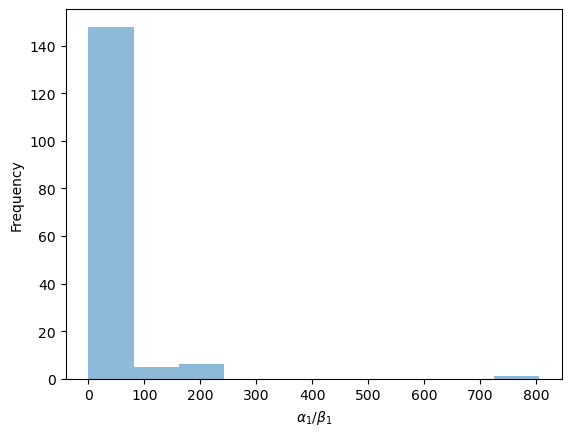

In [5]:
PyPlot.hist(df_pars[:,2]./df_pars[:,4], alpha = 0.5);
PyPlot.xlabel(L"\alpha_1/\beta_1"); PyPlot.ylabel("Frequency");

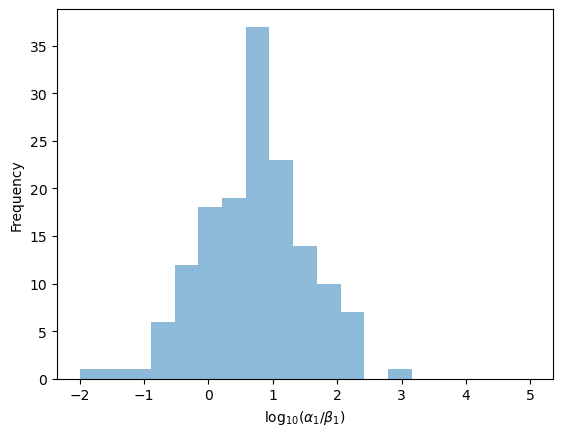

In [4]:
PyPlot.hist(log10.(df_pars[:,2]./df_pars[:,4]), alpha = 0.5, bins = LinRange(-2.0, 5, 20));
PyPlot.xlabel(L"\log_{10}(\alpha_1/\beta_1)"); PyPlot.ylabel("Frequency");

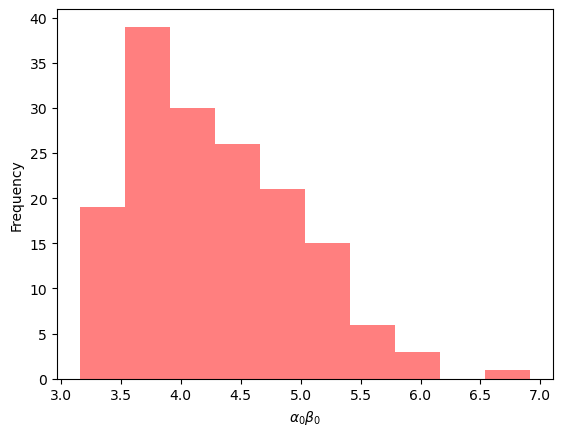

In [3]:
PyPlot.hist((df_pars[:,1]+df_pars[:,3]), alpha = 0.5, color ="r");
PyPlot.xlabel(L"\alpha_0\beta_0"); PyPlot.ylabel("Frequency");

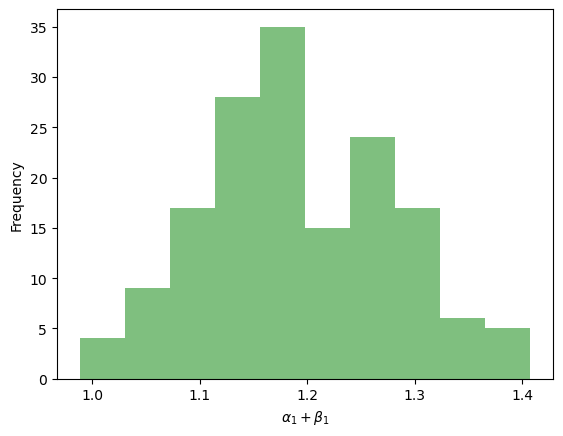

In [107]:
PyPlot.hist(lin_opt_pars_df[:,2]+lin_opt_pars_df[:,4], alpha = 0.5, color ="g");
PyPlot.xlabel(L"\alpha_1+\beta_1"); PyPlot.ylabel("Frequency");

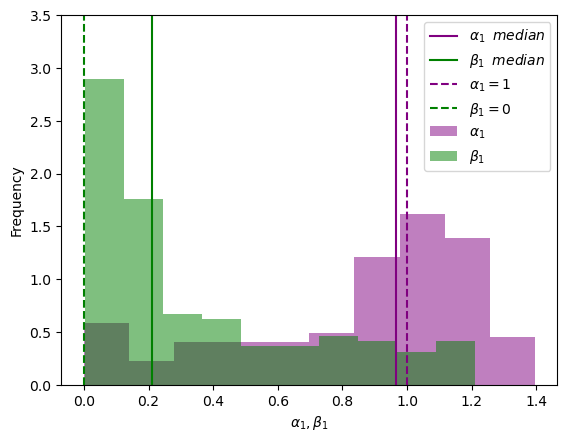

In [12]:
PyPlot.hist(df_pars[:,2], alpha = 0.5, color ="purple", label=L"\alpha_1", density = true);
PyPlot.hist(df_pars[:,4], alpha = 0.5, color ="g", label=L"\beta_1", density = true);

PyPlot.plot([median(df_pars[:,2]),median(df_pars[:,2])],[0,80], color = "purple", label = L"\alpha_1\;\; median")
PyPlot.plot([median(df_pars[:,4]),median(df_pars[:,4])],[0,80], color = "g", label = L"\beta_1\;\; median")

PyPlot.plot([true_par[2],true_par[2]],[0,40], color = "purple", linestyle = "dashed", label = L"\alpha_1 = 1");
PyPlot.plot([true_par[4],true_par[4]],[0,40], color = "g", linestyle = "dashed", label = L"\beta_1 = 0");

PyPlot.xlabel(L"\alpha_1, \beta_1"); PyPlot.ylabel("Frequency"); PyPlot.legend(); PyPlot.ylim([0,3.5]);
PyPlot.savefig("/home/s1402978/Desktop/Tanouchi-Inference-Project/MEK gm/a1b1-tr.png",dpi=1000)

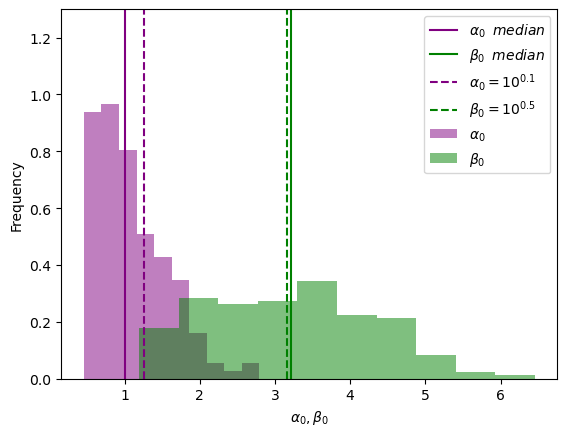

In [13]:
PyPlot.hist(df_pars[:,1], alpha = 0.5, color ="purple", label=L"\alpha_0", density = true);
PyPlot.hist(df_pars[:,3], alpha = 0.5, color ="g", label=L"\beta_0", density = true);

PyPlot.plot([median(df_pars[:,1]),median(df_pars[:,1])],[0,80], color = "purple", label = L"\alpha_0\;\; median")
PyPlot.plot([median(df_pars[:,3]),median(df_pars[:,3])],[0,80], color = "g", label = L"\beta_0\;\; median")

PyPlot.plot([10^true_par[1],10^true_par[1]],[0,40], color = "purple", linestyle = "dashed", label = L"\alpha_0 = 10^{0.1}");
PyPlot.plot([10^true_par[3],10^true_par[3]],[0,40], color = "g", linestyle = "dashed", label = L"\beta_0 = 10^{0.5}");

PyPlot.xlabel(L"\alpha_0, \beta_0"); PyPlot.ylabel("Frequency"); PyPlot.legend(); PyPlot.ylim([0,1.3]);
PyPlot.savefig("/home/s1402978/Desktop/Tanouchi-Inference-Project/MEK gm/a0b0-tr.png",dpi=1000)